In [31]:
import yfinance
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
data = yfinance.download("USDBRL=X", start="2020-01-01", end="2025-07-13", interval="1d")

C:\Users\mateu\AppData\Local\Temp\ipykernel_16616\1133883838.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yfinance.download("USDBRL=X", start="2020-01-01", end="2025-07-13", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [33]:
data = data['Close']

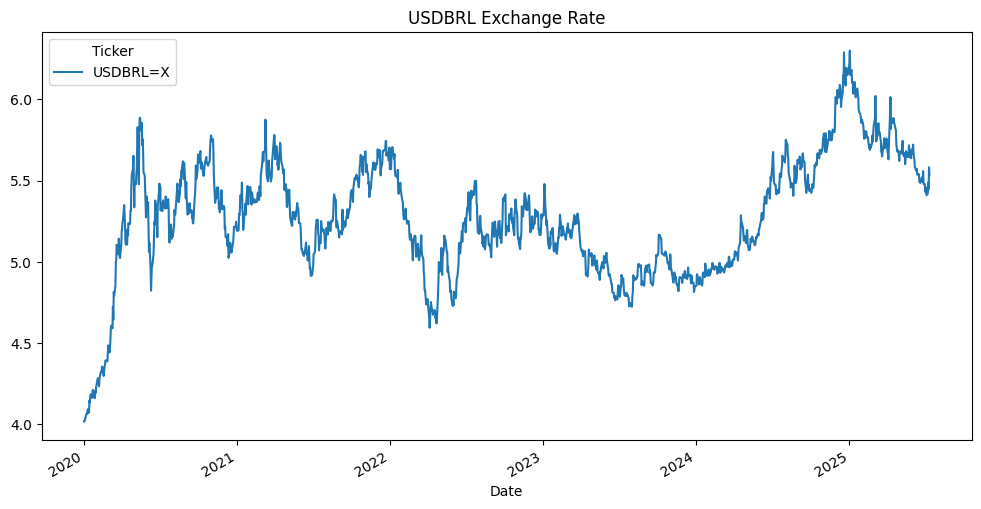

In [34]:
data.plot(figsize=(12, 6))
plt.title("USDBRL Exchange Rate")
plt.xlabel("Date")
plt.show()

In [35]:
data['mean'] = data['USDBRL=X'].rolling(window=50).mean()

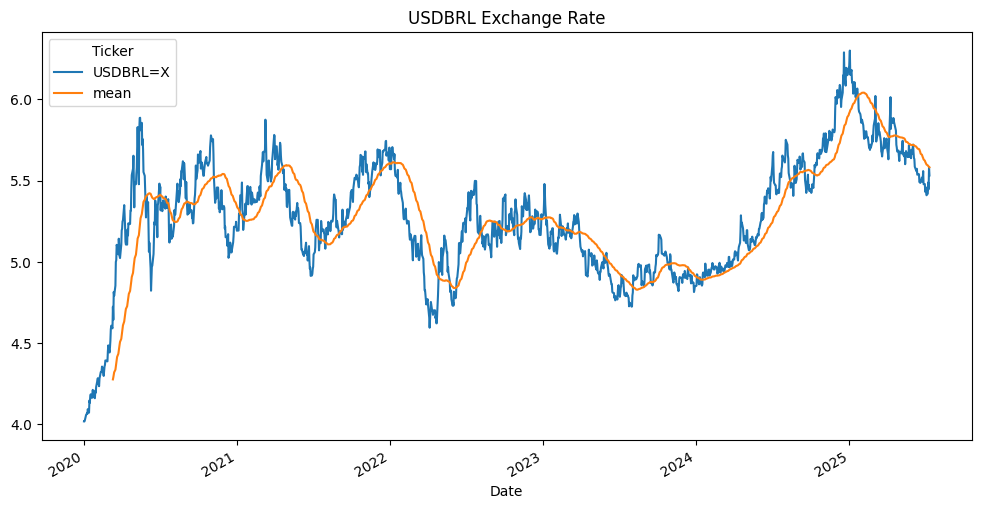

In [36]:
data.plot(figsize=(12, 6))
plt.title("USDBRL Exchange Rate")
plt.xlabel("Date")
plt.show()

In [37]:
# verificar se a serie é estacionária
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['USDBRL=X'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

ADF Statistic: -3.758229173681506
p-value: 0.0033647937357304423
A série é estacionária


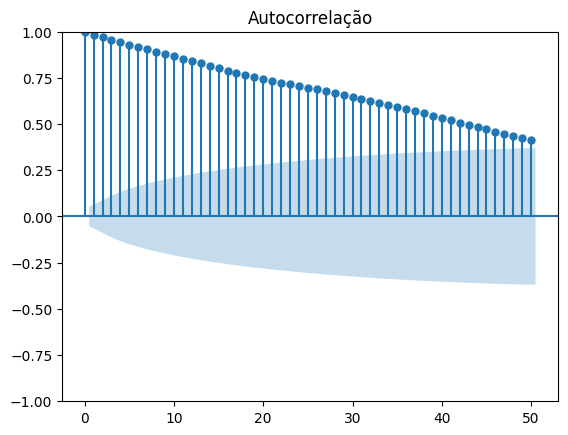

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['USDBRL=X'], lags=50)
plt.title("Autocorrelação")
plt.show()

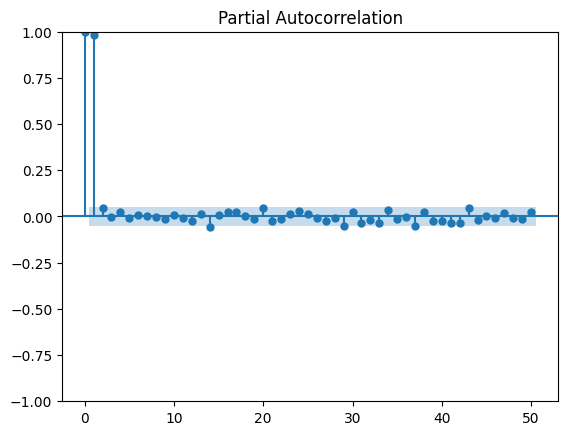

In [39]:
plot_pacf(data['USDBRL=X'], lags=50)
plt.show()

In [40]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(data['USDBRL=X'])
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

if kpss_result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

KPSS Statistic: 0.7197058209382887
p-value: 0.011754016278337389
A série é estacionária


In [41]:
data['diff'] = data['USDBRL=X'].diff().apply(lambda x: 0 if pd.isna(x) else x)

<Axes: xlabel='Date'>

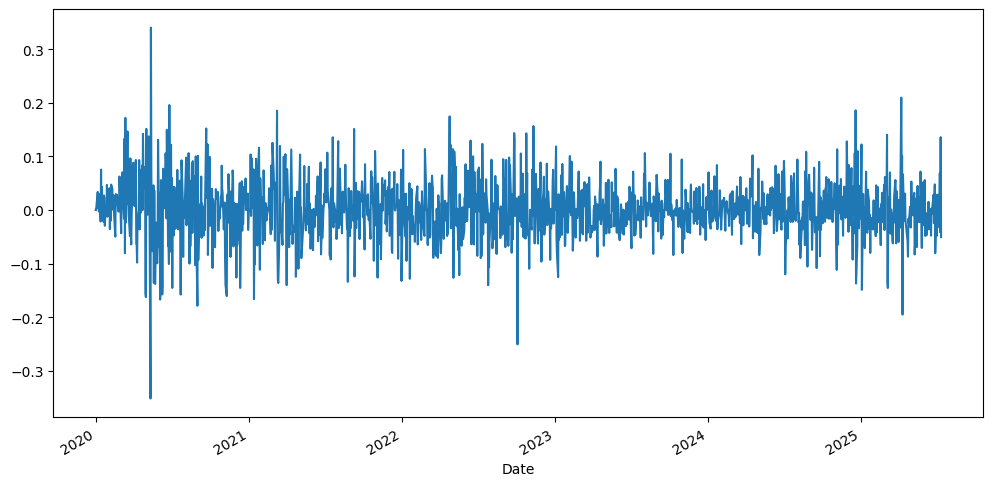

In [42]:
data['diff'].plot(figsize=(12, 6))

## Example 1

In [43]:
# timesgeneretor tensoflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [44]:
series = data['USDBRL=X'].values

In [45]:
scalar = MinMaxScaler()
series = scalar.fit_transform(series.reshape(-1, 1))

In [46]:
train_index = int(len(series) * 0.8)


# Split the data into training and testing sets
train = series[:train_index]
test  = series[train_index:]


# Create Timeseries Generators
train_generator = TimeseriesGenerator(
    train, train, length=40, batch_size=32
)
test_generator = TimeseriesGenerator(
    test, test, length=40, batch_size=32
)

total = TimeseriesGenerator(
    series, series, length=50, batch_size=32
)

In [47]:
1440/40

36.0

In [48]:
train_index-50

1102

In [49]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
])

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
lr = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)


model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=lr, clipvalue=1,use_ema=True),
    metrics=[keras.metrics.mean_absolute_error]
)

In [51]:
model.fit(
    train_generator,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
    validation_data=test_generator,
)

Epoch 1/20


c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.3622 - mean_absolute_error: 0.4618 - val_loss: 0.1509 - val_mean_absolute_error: 0.3769
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0179 - mean_absolute_error: 0.1103 - val_loss: 0.0111 - val_mean_absolute_error: 0.0795
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0304 - mean_absolute_error: 0.1365 - val_loss: 0.0129 - val_mean_absolute_error: 0.0871
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0211 - mean_absolute_error: 0.1190 - val_loss: 0.1944 - val_mean_absolute_error: 0.4305
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0384 - mean_absolute_error: 0.1564 - val_loss: 0.0483 - val_mean_absolute_error: 0.2013


In [52]:
predicoes_completas = []

# Predições no treino
janela_tempo = 40

entrada_atual = series[:janela_tempo]


for i in range(len(series)-40):
    pred = model.predict(entrada_atual.reshape(1, janela_tempo, 1), verbose=0)
    predicoes_completas.append(pred[0, 0])
    entrada_atual = np.append(entrada_atual[1:], series[i + janela_tempo])

In [77]:
entrada_atual = series[-janela_tempo:]

predicoes_futuro = []
for _ in range(100):
    pred = model.predict(entrada_atual.reshape(1, janela_tempo, 1), verbose=0)
    predicoes_futuro.append(pred[0, 0])
    
    entrada_atual = np.append(entrada_atual[1:], pred[0, 0])
    entrada_atual = entrada_atual[-janela_tempo:]

In [54]:
len(predicoes_completas), len(series)

(1400, 1440)

In [80]:
ultimo_indice_real = len(series[40:]) - 1
indices_futuros = np.arange(ultimo_indice_real + 1, ultimo_indice_real + 1 + 100)

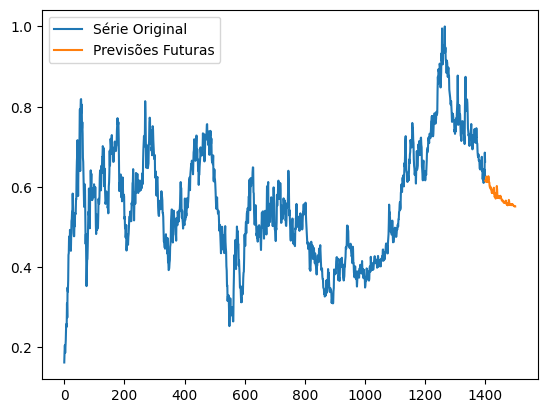

In [ ]:
plt.plot(predicoes_completas, label='Predições')
plt.plot(series[40:], label='Série Original')
plt.plot(indices_futuros, predicoes_futuro, label='Previsões Futuras')
plt.legend()
plt.show()

### Exemplo 2

In [90]:
model = keras.models.Sequential([
    keras.layers.GRU(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.GRU(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
])
model.summary()

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, None, 50)       │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, None, 50)       │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 1)        │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=lr, clipvalue=1,use_ema=True),
    metrics=[keras.metrics.mean_absolute_error]
)

In [92]:
series_total = TimeseriesGenerator(
    series, series, length=50, batch_size=32
)

In [113]:
history = model.fit(
    series_total,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0170 - mean_absolute_error: 0.1049
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0206 - mean_absolute_error: 0.1163
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0138 - mean_absolute_error: 0.0957
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0117 - mean_absolute_error: 0.0874
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0128 - mean_absolute_error: 0.0884
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0136 - mean_absolute_error: 0.0923
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0158 - mean_absolute_error: 0.0992
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0116 - mean_absolute_error: 0.0835
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0089 - mean_absolute_error: 0.0748
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0105 - mean_absolute_error: 0.0824
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 

Plotando

In [114]:
janela_tempo = 50

In [119]:
predicoes_completas = []

pred = model.predict(series_total)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [126]:
ultimo_ = series[-janela_tempo:]

predicoes_completas = []

for i in range(100):
    predict = model.predict(ultimo_.reshape(1, janela_tempo, 1), verbose=0)
    predicoes_completas.append(predict[0, 0])
    ultimo_ = np.append(ultimo_[1:], predict[0, 0])

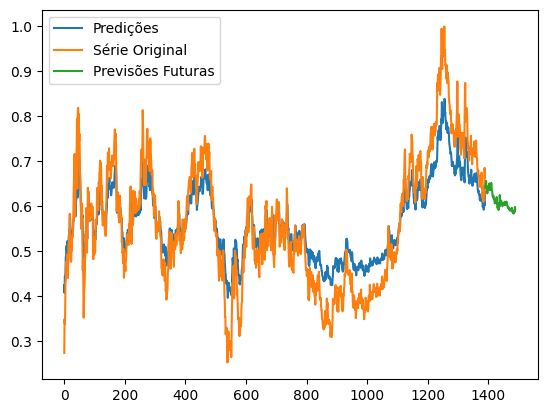

In [ ]:
plt.plot(pred[:, -1, 0], label='Predições')
plt.plot(series[50:], label='Série Original')
plt.plot(np.arange(len(series[50:]), len(series[50:]) + len(predicoes_completas)), predicoes_completas, label='Previsões Futuras')
plt.legend()
plt.show()

In [130]:
inv_pred = scalar.inverse_transform(pred[:, -1, 0].reshape(-1, 1))
inv_series = scalar.inverse_transform(series.reshape(-1, 1))
inv_futuro = scalar.inverse_transform(np.array(predicoes_futuro).reshape(-1, 1))

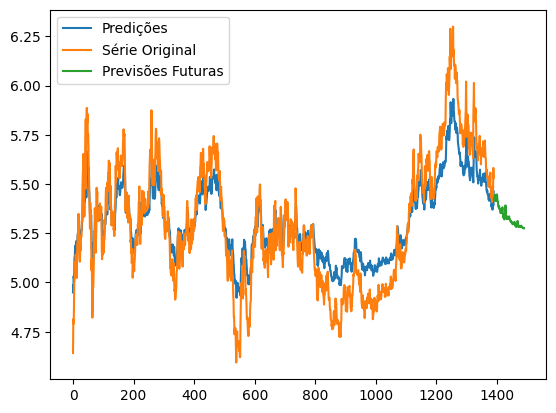

In [131]:
plt.plot(inv_pred, label='Predições')
plt.plot(inv_series[50:], label='Série Original')
plt.plot(np.arange(len(inv_series[50:]), len(inv_series[50:]) + len(inv_futuro)), inv_futuro, label='Previsões Futuras')
plt.legend()
plt.show()

### Exemplo 3